In [1]:
# import pandas as pd

# df = pd.read_csv("Dask/magnetism.csv")
# df

In [2]:
# float64_cols = list(df.select_dtypes(include='float64'))
# df[float64_cols] = df[float64_cols].astype('float32')

In [3]:
# df.iloc[:,3].values.dtype

In [4]:
# import pandas as pd
# from darts import TimeSeries

# # Assuming 'your_dataset.csv' is a string containing the dataset

# # df = pd.read_csv(pd.compat.StringIO('your_dataset.csv'))

# # Convert the 'Timestamp' column to datetime type
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# time_series_list = []
# for ccr_id, group in df.groupby('Magnetism_ID'):
#     # Sort the group by 'Timestamp' if not already sorted
#     group.sort_values('Timestamp', inplace=True)
    
#     # Set the 'Timestamp' column as the index
#     group.set_index('Timestamp', inplace=True)
    
#     # Exclude the 'CCR_ID' column from numeric conversion and resampling
#     value_cols = ['Elapsed time (minutes)', 'Set B field (T)', 'B field (T)', 'Ramp speed (T/min)', 'Voltage (V)', 'Inner Lower Temperature', 'Outer Lower Temperature', 'Inner Upper Temperature', 'Outer Upper Temperature', '1st Stage Temperature', 'Shield Temperature', '2nd Stage Temperature', ]
#     # value_cols = ['Elapsed time (minutes)','Setpoint (K)','Sensor A (K)','Sensor B (K)', 'Heater Output % (0-100)', 'Heater Range (integer 0-5)', 'Slope','Intercept','Sensor C (K) or sensor A (sensor unit)','Sensor D (K) or sensor B (sensor unit)']
    
#     # Convert the numeric columns to numeric format, handling non-numeric values as NaN
#     for col in value_cols:
#         group[col] = pd.to_numeric(group[col], errors='coerce')
    
#     # Select only numeric columns for resampling
#     numeric_cols = group.select_dtypes(include='number').columns
    
#     # Resample the numeric columns to a fixed frequency
#     group_resampled = group[numeric_cols].resample('1T').mean()  # Adjust '5S' to the desired frequency
    
#     # Handle missing values if necessary
#     group_resampled = group_resampled.fillna(method='ffill')  # Forward fill missing values, or choose another appropriate method
    
#     # Convert the resampled DataFrame to a Darts TimeSeries object
#     time_series = TimeSeries.from_dataframe(group_resampled, value_cols=value_cols)
    
#     time_series_list.append(time_series)


In [6]:
import pickle

In [7]:
# with open('timeseries','wb') as f: pickle.dump(time_series_list, f)

In [10]:
with open('timeseries','rb') as f: time_series_loaded = pickle.load(f)

In [11]:
# print(time_series_loaded == time_series_list)

In [12]:
time_series_list = time_series_loaded

In [13]:
# fix python path if working locally
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [14]:
time_series_list_scaled = []

for time_series in time_series_list:
    scaler = Scaler()
    time_series_list_scaled.append(scaler.fit_transform(time_series))

In [15]:
# print(time_series_list_scaled[0].columns)
from darts import TimeSeries
temp = []
# Assuming you have a Darts TimeSeries object named 'ts'

# Convert the TimeSeries to a pandas DataFrame
for ts in time_series_list_scaled:
    df = ts.pd_dataframe()

    # Rename the columns in the pandas DataFrame
    new_column_names = ['Normalized Elapsed time (minutes)', 'Normalized Set B field (T)', 'Normalized B field (T)',
       'Normalized Ramp speed (T/min)', 'Normalized Voltage (V)', 'Normalized Inner Lower Temperature',
       'Normalized Outer Lower Temperature', 'Normalized Inner Upper Temperature',
       'Normalized Outer Upper Temperature', 'Normalized 1st Stage Temperature',
       'Normalized Shield Temperature', 'Normalized 2nd Stage Temperature']  # Replace with the new column names you want
    df.columns = new_column_names

    # Convert the modified pandas DataFrame back to a Darts TimeSeries
    temp.append(TimeSeries.from_dataframe(df))
time_series_list_scaled = temp
print(time_series_list_scaled[0].columns)

Index(['Normalized Elapsed time (minutes)', 'Normalized Set B field (T)',
       'Normalized B field (T)', 'Normalized Ramp speed (T/min)',
       'Normalized Voltage (V)', 'Normalized Inner Lower Temperature',
       'Normalized Outer Lower Temperature',
       'Normalized Inner Upper Temperature',
       'Normalized Outer Upper Temperature',
       'Normalized 1st Stage Temperature', 'Normalized Shield Temperature',
       'Normalized 2nd Stage Temperature'],
      dtype='object', name='component')


In [16]:
from darts import TimeSeries

covariates = []
for i in range(len(time_series_list)):
    ts_df = (time_series_list[i]).pd_dataframe()
    columns_to_keep = ['Set B field (T)', 'Elapsed time (minutes)', 'Ramp speed (T/min)', 'Inner Lower Temperature', 
                       'Outer Lower Temperature', 'Inner Upper Temperature',
                       'Outer Upper Temperature', '1st Stage Temperature',
                       'Shield Temperature', '2nd Stage Temperature']
    covariate_ts_df = ts_df[columns_to_keep]
    covariates.append(TimeSeries.from_dataframe(covariate_ts_df))


In [17]:
updated_covariates = []
for i in range(len(covariates)):
    df = covariates[i].pd_dataframe()
    # for time_series in time_series_list_scaled:
    temp = time_series_list_scaled[i].pd_dataframe()
    for col in temp.columns:
        df[col] = temp[col]
    updated_covariates.append(TimeSeries.from_dataframe(df))
    
print(updated_covariates[0].columns)
covariates = updated_covariates

Index(['Set B field (T)', 'Elapsed time (minutes)', 'Ramp speed (T/min)',
       'Inner Lower Temperature', 'Outer Lower Temperature',
       'Inner Upper Temperature', 'Outer Upper Temperature',
       '1st Stage Temperature', 'Shield Temperature', '2nd Stage Temperature',
       'Normalized Elapsed time (minutes)', 'Normalized Set B field (T)',
       'Normalized B field (T)', 'Normalized Ramp speed (T/min)',
       'Normalized Voltage (V)', 'Normalized Inner Lower Temperature',
       'Normalized Outer Lower Temperature',
       'Normalized Inner Upper Temperature',
       'Normalized Outer Upper Temperature',
       'Normalized 1st Stage Temperature', 'Normalized Shield Temperature',
       'Normalized 2nd Stage Temperature'],
      dtype='object', name='component')


In [18]:
from darts import TimeSeries

# ts_df = ts.pd_dataframe()
time_final = []
for i in range(len(time_series_list)):
    ts_df = (time_series_list[i]).pd_dataframe()
    columns_to_keep = ['B field (T)', 'Voltage (V)', ]
    covariate_ts_df = ts_df[columns_to_keep]
    time_final.append(TimeSeries.from_dataframe(covariate_ts_df))
    
print(len(time_final[0].columns))
# time_final = time_series_list

2


In [19]:
# load data
train, val = [], []
VAL_LEN = 200
temp1, temp2 = [], []

for i in range(len(time_final)):
    series = time_final[i]
    train.append(series[:-VAL_LEN])
    val.append(series[-VAL_LEN:])
    temp1.append(covariates[i][-VAL_LEN:])
    temp2.append(covariates[i][:-VAL_LEN])

# for time_series in time_final:
#     series = time_series.astype(np.float32)
#     train.append(series[:-VAL_LEN])
#     val.append(series[-VAL_LEN:])
    
    
# for time_series in covariates:
#     series = time_series.astype(np.float32)
#     temp.append(series[:-VAL_LEN])
val_past_covariates_past = temp1
covariates = temp2

# split in train / validation (note: in practice we would also need a test set)
# train, val = 


In [20]:
train[1].dtype

dtype('float32')

In [21]:
print(len(train[0]))
print(len(covariates[1]))

14390
9634


In [22]:
print(len(val[0]))

200


In [23]:
train = train[:2]
val = val[:2]
covariates = covariates[:2]
val_past_covariates_past = val_past_covariates_past[:2]

In [21]:
# class Trial():
#     def suggest_int(self, name, low, high):
#         return low
#     def suggest_categorical(self, name, cats):
#         return cats[0]
#     def suggest_float(self, name, low, high, log = False):
#         return low
        

In [ ]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import smape
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

# scale
# scaler = Scaler(MaxAbsScaler())
# train = scaler.fit_transform(train)
# val = scaler.transform(val)

# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 15, 120)
    out_len = trial.suggest_int("out_len", 1, in_len-1)
    d_model_length = trial.suggest_int("d_model_length", 60, 68)
    num_encoder_layers_temp = trial.suggest_int("num_encoder_layers_temp", 1, 5)
    num_decoder_layers_temp = trial.suggest_int("num_decoder_layers_temp", 1, 5)

    # Other hyperparameters
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    num_filters = trial.suggest_int("num_filters", 1, 5)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    # include_year = trial.suggest_categorical("year", [False, True])

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [pruner, early_stopper]
    
    num_workers = 4
        
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "devices": [0],
        "callbacks": callbacks,
    }

    encoders = None #look into add encoders

    # reproducibility
    torch.manual_seed(42)
    # kernel_size', 'num_filters', 'weight_norm', 'dilation_base']`
    # build the TCN model
    model = TransformerModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=32,
        n_epochs=4,
        nr_epochs_val_period=1,
        num_encoder_layers = num_encoder_layers_temp,
        num_decoder_layers = num_decoder_layers_temp,
        # d_model = d_model_length,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        add_encoders=encoders,
        likelihood=GaussianLikelihood(),
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tcn_model_1",
        force_reset=True,
        save_checkpoints=True,
    )
    
    # model = TransformerModel(
    # input_chunk_length=in_len,
    # output_chunk_length=out_len,
    # model_name="test5",
    # activation="relu",
    # # random_state=42,
    # save_checkpoints=True,
    # # force_reset=True,
    # pl_trainer_kwargs = {"accelerator": "gpu", "devices": [1]}
    # )
    
    
    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    # model_val_set = scaler.transform(series[-(VAL_LEN + in_len) :])
    # model_val_set = []
    # for time_series in time_final:
    #     series = time_series.astype(np.float32)
    #     model_val_set.append(series[-(VAL_LEN + in_len) :])

    # train the model
    model.fit(
        series=train,
        val_series=val,
        num_loader_workers=1,
        past_covariates = covariates,
        val_past_covariates=val_past_covariates_past
    )
    
#     model.fit(
#         series=train,
#         past_covariates=covariates,
#     );

    # reload best model over course of training
    model = TransformerModel.load_from_checkpoint("tcn_model")
    
    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=train[0], n=VAL_LEN)
    smapes = smape(val[0], preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)
    # if smape_val== np.nan:
    #     print("nan")
    return smape_val if smape_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the sMAPE on the validation set
def run_trial():
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=3, callbacks=[print_callback])
        
if __name__ == "__main__":
    run_trial()
    # objective(Trial())


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 200.0, Current params: {'in_len': 96, 'out_len': 66, 'd_model_length': 62, 'num_encoder_layers_temp': 3, 'num_decoder_layers_temp': 4, 'kernel_size': 3, 'num_filters': 5, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.05086792551951613, 'lr': 0.0009630404524546119}
Best value: 200.0, Best params: {'in_len': 96, 'out_len': 66, 'd_model_length': 62, 'num_encoder_layers_temp': 3, 'num_decoder_layers_temp': 4, 'kernel_size': 3, 'num_filters': 5, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.05086792551951613, 'lr': 0.0009630404524546119}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 200.0, Current params: {'in_len': 112, 'out_len': 36, 'd_model_length': 60, 'num_encoder_layers_temp': 4, 'num_decoder_layers_temp': 4, 'kernel_size': 2, 'num_filters': 2, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.0740368890118643, 'lr': 0.0005261755690624826}
Best value: 200.0, Best params: {'in_len': 96, 'out_len': 66, 'd_model_length': 62, 'num_encoder_layers_temp': 3, 'num_decoder_layers_temp': 4, 'kernel_size': 3, 'num_filters': 5, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.05086792551951613, 'lr': 0.0009630404524546119}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [4]:
# fix python path if working locally
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

2023-07-31 08:43:10 darts.models WARNING: The statsforecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


In [76]:
num = 1

In [77]:
loaded_model = TransformerModel.load_from_checkpoint('transformer-3386/T0002')

In [78]:
n_forecast = len(val[num])  # Replace `test` with your test set
pred_series = loaded_model.predict(n=n_forecast, series=train[num])  # Adjust the `n` parameter as needed

Predicting: 0it [00:00, ?it/s]

In [79]:
from darts.metrics import mape, rmse

mape_score = mape(pred_series, val[num])  # Replace `test` with your true future values
rmse_score = rmse(pred_series, val[num])  # Replace `test` with your true future values

print(f"MAPE: {mape_score:.2f}%")
print(f"RMSE: {rmse_score:.2f}")

MAPE: 84.17%
RMSE: 1.97


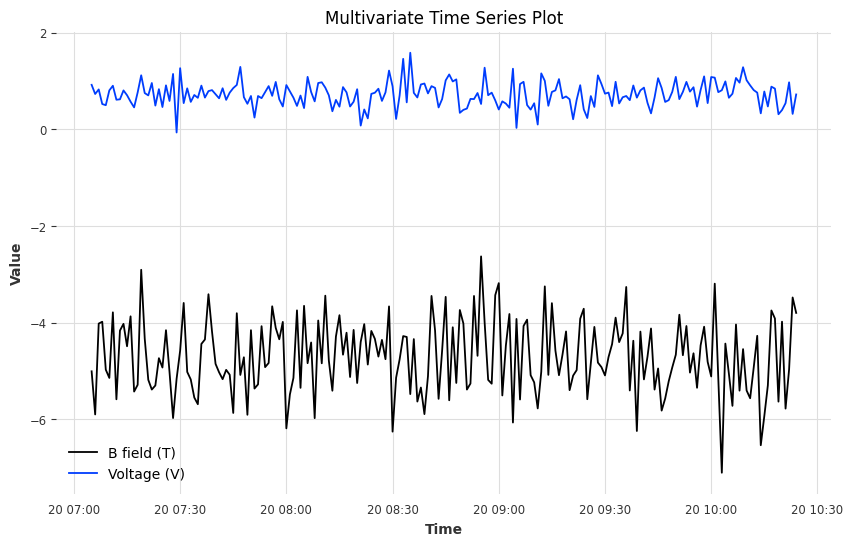

In [80]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming you have a multivariate Darts time series named 'multivariate_time_series'

# Convert the Darts time series to a Pandas DataFrame
df = (pred_series).pd_dataframe()

# Plotting the multivariate time series
plt.figure(figsize=(10, 6))

# Plot each variable separately
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multivariate Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()


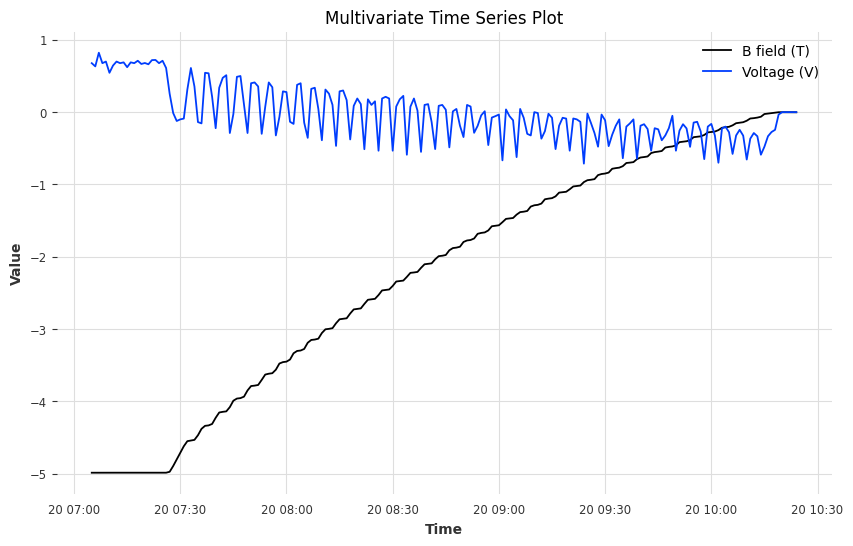

In [81]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming you have a multivariate Darts time series named 'multivariate_time_series'

# Convert the Darts time series to a Pandas DataFrame
df = (val[num]).pd_dataframe()

# Plotting the multivariate time series
plt.figure(figsize=(10, 6))

# Plot each variable separately
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multivariate Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()
